# Single qubit: phase estimation
This example shows a one-qubit interference experiment.

In [16]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteVariableState, HGate, Phase
from squint.ops.noise import BitFlipChannel

In [21]:
circuit = Circuit(backend="mixed")

#          ____      ___________      ____
# |0> --- | H | --- | Rz(\phi) | --- | H | ----
#         ----      -----------      ----

circuit.add(DiscreteVariableState(wires=(0,), n=(0,)))
circuit.add(HGate(wires=(0,)))
circuit.add(Phase(wires=(0,), phi=0.1 * jnp.pi), "phase")
circuit.add(HGate(wires=(0,)))
circuit.add(BitFlipChannel(wires=(0,), p=0.1))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   Phase(wires=(0,), phi=weak_f32[]),
│   3:
│   HGate(wires=(0,)),
│   4:
│   BitFlipChannel(wires=(0,), p=weak_f32[])
  },
  _backend='mixed'
)

In [22]:
pprint(circuit.subscripts)

'a,b,ac,bd,ce,df,eg,fh,\U0001dcc0gi,\U0001dcc0hj->ij'

In [23]:
circuit.ops["phase"].phi

Array(0.31415927, dtype=float32, weak_type=True)

In [24]:
params, static = eqx.partition(circuit, eqx.is_inexact_array)

pprint(params)
pprint(static)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   1:
│   HGate(wires=(None,)),
│   'phase':
│   Phase(wires=(None,), phi=weak_f32[]),
│   3:
│   HGate(wires=(None,)),
│   4:
│   BitFlipChannel(wires=(None,), p=weak_f32[])
  },
  _backend=None
)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   Phase(wires=(0,), phi=None),
│   3:
│   HGate(wires=(0,)),
│   4:
│   BitFlipChannel(wires=(0,), p=None)
  },
  _backend='mixed'
)

In [25]:
sim = circuit.compile(params, static, dim=2, optimize="greedy")

/Users/benjamin/Desktop/1 - Projects/Quantum Intelligence Lab/repos/squint/src/squint/ops/base.py:48: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in array is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array(


In [26]:
ket = sim.amplitudes.forward(params)
dket = sim.amplitudes.grad(params)
prob = sim.prob.forward(params)
dprob = sim.prob.grad(params)

print(f"{ket.shape}, {ket.dtype}")
print(f"{prob.shape}, {prob.dtype}")

(2, 2), complex64
(2,), float32


2025-03-06 10:29:07.326 | INFO     | squint.circuit:compile:114 -   Complete contraction:  a,ab,bc,cd->d
         Naive scaling:  4
     Optimized scaling:  3
      Naive FLOP count:  6.400e+1
  Optimized FLOP count:  3.200e+1
   Theoretical speedup:  2.000e+0
  Largest intermediate:  4.000e+0 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   2           GEMM                ab,a->b                            bc,cd,b->d
   3           GEMM              cd,bc->db                               b,db->d
   2           GEMM                db,b->d                                  d->d


[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 2.1000049114227295)]

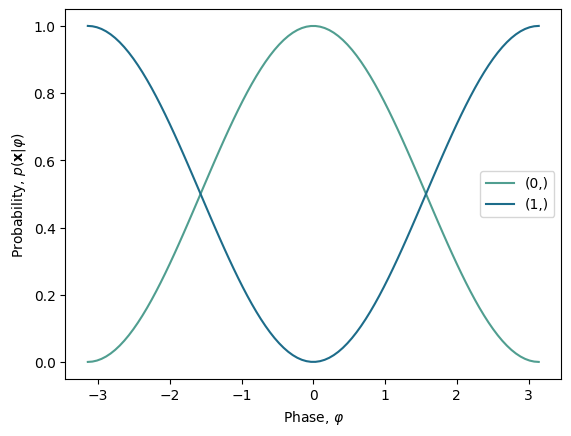

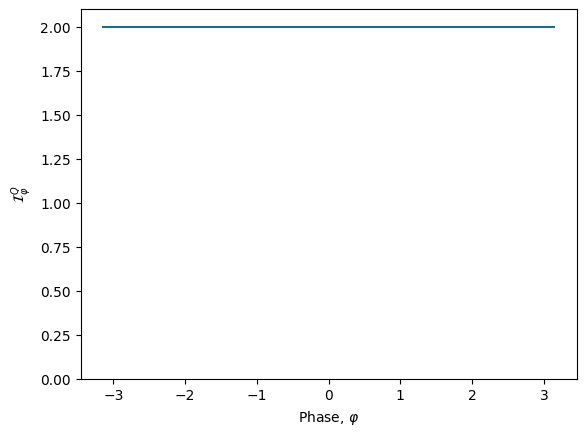

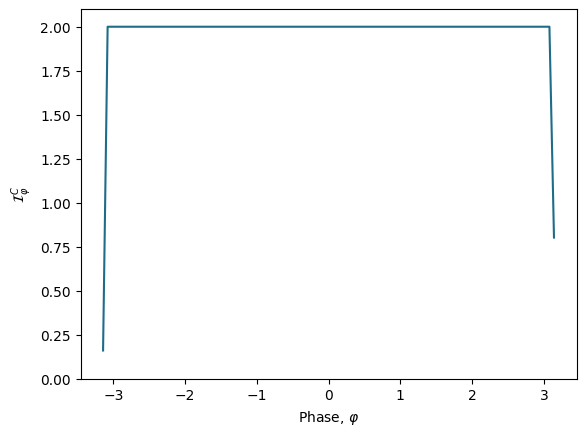

In [6]:
sim = circuit.compile(params, static, dim=2, optimize="greedy")

get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.prob.forward)(params)
cfims = eqx.filter_vmap(sim.prob.cfim, in_axes=(None, 0))(get, params)
qfims = eqx.filter_vmap(sim.amplitudes.qfim, in_axes=(None, 0))(get, params)

colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)